In [17]:
#Universal Bank - Fitting a Logistic Regression Model

In [18]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score


In [11]:
bank_df = pd.read_csv('UniversalBank.csv')
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]

# Treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}
bank_df.Education.cat.rename_categories(new_categories, inplace=True)
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])

# Partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

#The columns ID and ZIP Code are not relevant for model building and therefore removed. Treat Education as categorical
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.105194006575854
            Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.051667    0.052952  0.058676  0.609565  0.240421   0.00101   

       Securities_Account  CD_Account    Online  CreditCard  \
coeff           -1.030108    3.648152 -0.678944   -0.961048   

       Education_Graduate  Education_Advanced/Professional  
coeff             4.19873                         4.358777  

AIC -709.1524769205962


In [12]:
predictors = ['Income']
outcome = 'Personal_Loan'

y = bank_df[outcome]
X = bank_df[predictors]

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -6.048919279034497
               Income
coefficient  0.036343

AIC 843.5163143186965


In [13]:
#Predicting to get probabilities
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.952399  0.047601          0
932        0  0.878526  0.121474          0
2721       1  0.440692  0.559308          1
702        1  0.889689  0.110311          0


In [14]:
#Generating the confusion matrix
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9080)

       Prediction
Actual    0    1
     0 2632   81
     1  195   92
Confusion Matrix (Accuracy 0.9110)

       Prediction
Actual    0    1
     0 1763   44
     1  134   59


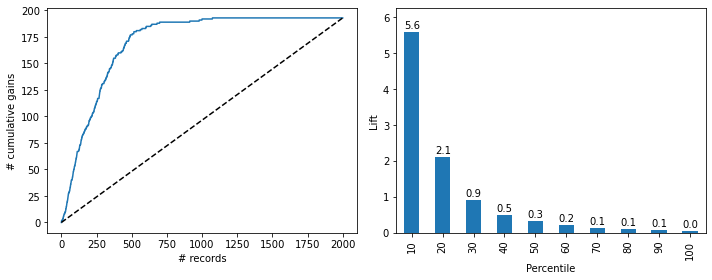

In [16]:
#Plotting the Gains and Decile Chart
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.savefig("mytest.png")
plt.show()